# Spatial features

Find largest distance in current dataset for normalization!

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import math
import multiprocessing
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd

from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import Fingerprint, PhysicoChemicalFeatures, SpatialFeatures
from kinsim_structure.encoding import PharmacophoreSizeFeatures, SideChainOrientationFeature, ExposureFeature

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path)

In [7]:
klifs_metadata.head()

,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,...,in,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...
1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",...,in,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...
2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,...,in,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...
3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,...,in,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...
4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,-,...,in,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN


In [8]:
klifs_metadata.shape

(3917, 23)

In [9]:
klifs_metadata_entry = klifs_metadata.iloc[250]

## Maximum distance per molecule and per reference point

In [19]:
space = SpatialFeatures()

max_per_molecule = []

for index, row in klifs_metadata.iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
    space.from_molecule(ml.molecule)
    
    max_per_molecule.append(space.features.max(axis=0))

In [22]:
max_distances = pd.DataFrame(max_per_molecule)

In [25]:
max_distances

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
0,22.65,25.62,27.98,26.89
1,22.85,25.31,28.08,26.56
2,23.63,24.71,28.69,26.68
3,20.98,23.72,26.44,25.75
4,21.84,22.54,28.11,23.29
5,21.43,23.33,26.33,24.14
6,20.81,23.74,25.95,25.08
7,22.41,23.78,27.93,NaN
8,21.21,23.69,26.07,24.32
9,21.07,23.70,26.91,25.79


### Save data

In [27]:
with open(path_to_results / 'distances_max.p', 'wb') as f:
    pickle.dump(max_distances, f)

### Load and plot data

In [51]:
with open(path_to_results / 'distances_max.p', 'rb') as f:
    max_distances = pickle.load(f)

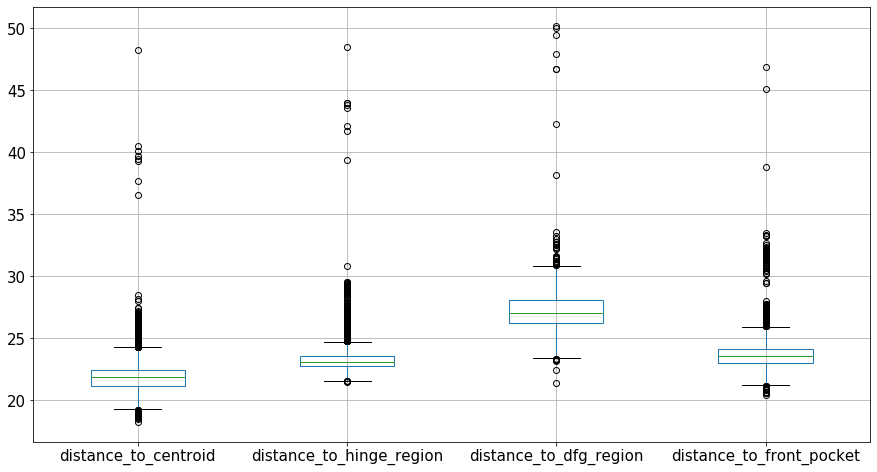

In [52]:
boxplot = max_distances.boxplot(figsize=(15,8), fontsize=15)

In [40]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_max_boxplot.png', dpi=300)

### Look at some of those >40 distances

In [45]:
max_distances[max_distances.distance_to_centroid > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [46]:
max_distances[max_distances.distance_to_hinge_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [47]:
max_distances[max_distances.distance_to_dfg_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [48]:
max_distances[max_distances.distance_to_front_pocket > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2833,48.20,48.51,47.91,38.83


In [50]:
klifs_metadata.index

RangeIndex(start=0, stop=3917, step=1)

In [8]:
klifs_metadata.iloc[2833]

Unnamed: 0                                                                2845
index                                                                     6942
kinase                                                                     PBK
family                                                                    TOPK
groups                                                                   Other
pdb_id                                                                    5j0a
chain                                                                        A
alternate_model                                                              -
species                                                                  Human
ligand_orthosteric_name                                                      -
ligand_orthosteric_pdb_id                                                    -
ligand_allosteric_name                            4&apos;-HYDROXYCINNAMIC ACID
ligand_allosteric_pdb_id                            

## Distances per molecule and per reference point

In [ ]:
!python spatial_features_stats.py

### Load data

In [14]:
with open(path_to_results / 'distances_all.p', 'rb') as f:
    all_distances = pickle.load(f)

### Analyse data

In [15]:
all_distances.shape

(328182, 7)

In [16]:
all_distances.reset_index(inplace=True)

In [17]:
all_distances.shape

(328182, 8)

In [18]:
all_distances.head()

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,metadata_index,qualityscore,resolution
0,1,17.19,12.80,19.08,14.13,2886,8.6,1.95
1,2,15.09,11.64,16.48,11.69,2886,8.6,1.95
2,3,12.41,9.24,15.13,8.24,2886,8.6,1.95
3,4,11.80,10.34,13.67,7.22,2886,8.6,1.95
4,5,12.80,12.41,12.79,9.24,2886,8.6,1.95


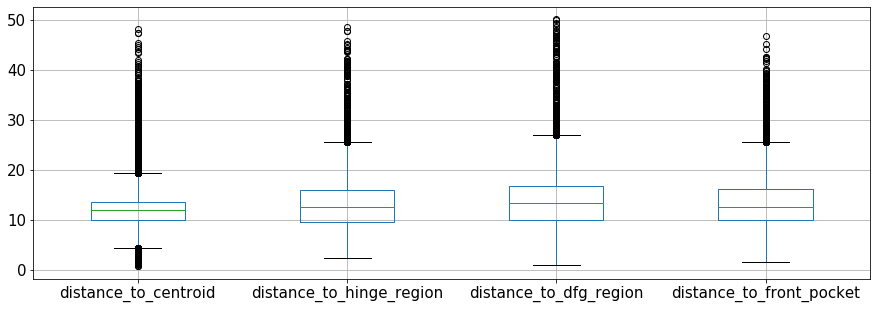

In [19]:
boxplot = all_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].boxplot(figsize=(15,5), fontsize=15)

In [20]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_all_boxplot.png', dpi=300)

### Reduce dataset by resolution and quality score

In [21]:
# Remove missing rows with missing values
print(f'{len(all_distances)}: Dataset')

all_distances.dropna(inplace=True)
print(f'{len(all_distances)}: Dataset without missing values')

328182: Dataset
315572: Dataset without missing values


In [22]:
# Round resolution and quality score
all_distances['resolution_bins'] = all_distances.resolution.apply(math.ceil)
all_distances['qualityscore_bins'] = all_distances.qualityscore.apply(math.ceil)

In [23]:
# Set interval of resolution and quality score
all_distances['resolution_bins'] = all_distances.resolution_bins.apply(lambda x: f'({x-1}, {x}]')
all_distances['qualityscore_bins'] = all_distances.qualityscore_bins.apply(lambda x: f'({x-1}, {x}]')

In [24]:
all_distances.head()

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,metadata_index,qualityscore,resolution,resolution_bins,qualityscore_bins
0,1,17.19,12.80,19.08,14.13,2886,8.6,1.95,"(1, 2]","(8, 9]"
1,2,15.09,11.64,16.48,11.69,2886,8.6,1.95,"(1, 2]","(8, 9]"
2,3,12.41,9.24,15.13,8.24,2886,8.6,1.95,"(1, 2]","(8, 9]"
3,4,11.80,10.34,13.67,7.22,2886,8.6,1.95,"(1, 2]","(8, 9]"
4,5,12.80,12.41,12.79,9.24,2886,8.6,1.95,"(1, 2]","(8, 9]"


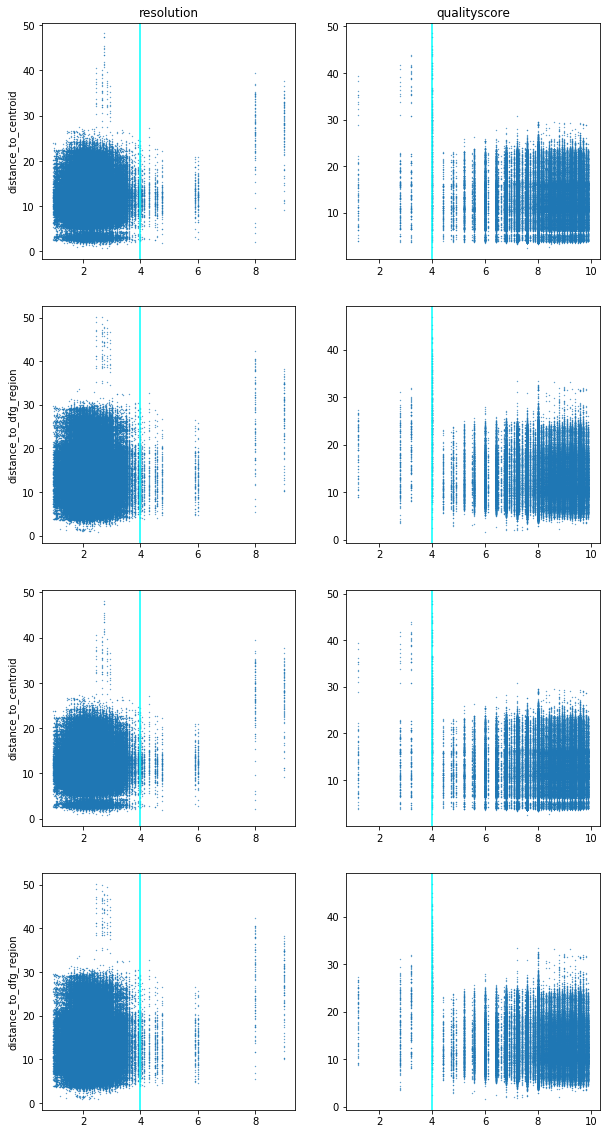

In [56]:
plt.figure(figsize=(10, 20))

x_categories = 'resolution qualityscore'.split()*4
y_categories = 'distance_to_centroid distance_to_hinge_region distance_to_dfg_region distance_to_front_pocket'.split()*2

for index, (x, y) in enumerate(zip(x_categories, y_categories)):

    plt.subplot(4, 2, index+1)
    plt.scatter(
        x=all_distances[x], 
        y=all_distances[y],
        s=0.1
    )
    if index in [0,1]:
        plt.title(x)
    if index in [0, 2, 4, 6]:
        plt.axvline(x=4, color='cyan')
        plt.ylabel(y)
    if index in [1, 3, 5, 7]:
        plt.axvline(x=4, color='cyan')
        
plt.savefig(path_to_results / 'distances_vs_resolution-qualityscore.png', dpi=300, bbox_inches='tight')

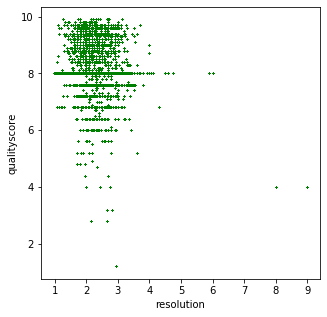

In [57]:
p = all_distances.plot.scatter(
    x='resolution', 
    y='qualityscore',
    s=0.1,
    color='green',
    figsize=(5,5)
)

plt.savefig(path_to_results / 'resolution_vs_qualityscore.png', dpi=300)

We want to remove large distances - how do we do this? At the level of resolution and qualityscore?

In [34]:
def row_greater_distance(data, cutoff):
    """
    Get all data with distances greater than a certain distance cutoff.
    """
    
    subset = data[
        (all_distances.distance_to_hinge_region > cutoff) |
        (all_distances.distance_to_dfg_region > cutoff) |
        (all_distances.distance_to_front_pocket > cutoff) |
        (all_distances.distance_to_centroid > cutoff)
    ]
    
    print(subset.shape)
    
    return subset

In [41]:
data_subset = row_greater_distance(all_distances, 30)[['qualityscore', 'resolution']]

(316, 10)


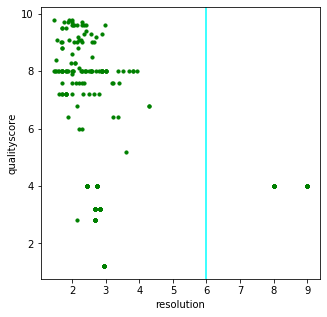

In [50]:
p = data_subset.plot.scatter(
    x='resolution', 
    y='qualityscore',
    s=10,
    color='green',
    figsize=(5,5)
)
p.axvline(x=6, color='cyan')
#p.ayhline(x=5, color='cyan')

In [36]:
def plot_parallel_coordinates_distances(data):
    plt.figure(figsize=(15, 5))
    
    print(f'Number of structures: {data.shape[0]}')

    pd.plotting.parallel_coordinates(
        data.dropna().sort_values(by='resolution_bins', ascending=False)[
            [
                'resolution_bins',
                'qualityscore',
                'distance_to_centroid', 
                'distance_to_hinge_region', 
                'distance_to_dfg_region', 
                'distance_to_front_pocket'
            ]
        ],
        'resolution_bins',
        colormap='viridis'
    )

    plt.show()

Number of structures: 168


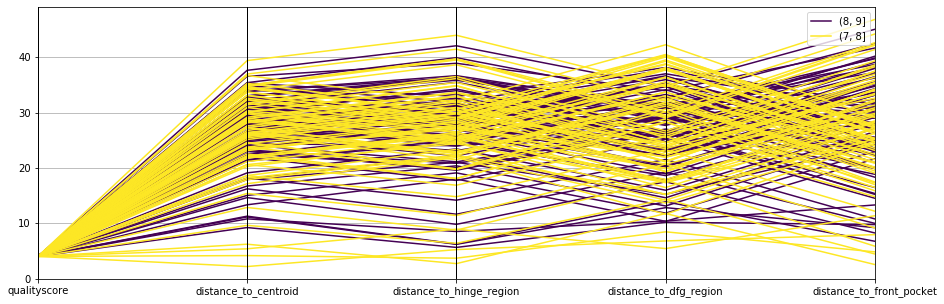

In [39]:
data = all_distances[all_distances.resolution > 6]
plot_parallel_coordinates_distances(data)

Number of structures: 2000


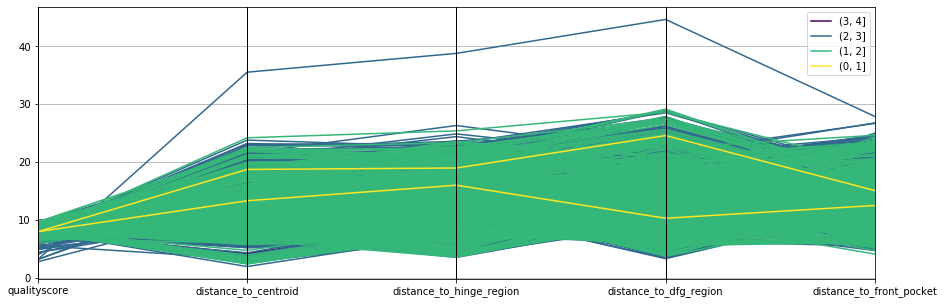

In [189]:
data = all_distances[all_distances.resolution <= 4].sample(2000)
plot_parallel_coordinates_distances(data)

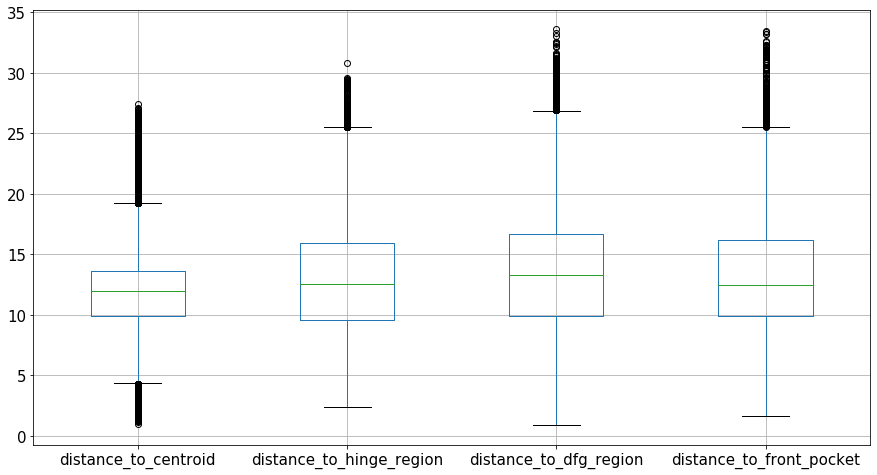

In [63]:
boxplot = reduced_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].boxplot(figsize=(15,8), fontsize=15)